In [2]:
import streamlit as st 

import pandas as pd 
import os
from Pylice_def.data import page as data_page
import Pylice_def.data.preprocess as prep
from Pylice_def.forecast import modelling
from Pylice_def.forecast import forecasts
import pandas as pd 
import numpy as np 
from Pylice_def.queing import simulation as sim
from Pylice_def.queing import page as q_page
from Pylice_def.shift_scheduling import page as shift_page
from Pylice_def.shift_scheduling.optimization import pylice_opt_model_hard, optimize_hard, pylice_opt_model_soft, optimize_soft
import pyomo.environ as pyo
import matplotlib.pyplot as plt 
import datetime as dt 
from matplotlib.patches import Patch


### INPUTS:

district = "112_Soer_Oest"
timeframe = 15
horizon = 9
earliest=  6
latest = 22
minimum_night = 3
minimum_day = 4
teamsize = 4
max_cap = 15
shift_lenghts = [6,7,8,9,10]
overlap = 45


### IMPORT
all_data = []
for file in os.listdir(f"..\data\List_Raw\\{district}"):
    file = f"..\\data\\List_Raw\\{district}\\" + file
    all_data.append(data_page.import_file(file))


call_types = ["112","02800"]
### Prepare
a, all_data, b, c = prep.prepare_data(all_data, timeframe)
for n in range(len(all_data)):
    data = all_data[n]
    call_type = call_types[n]
    ### Forecast
    x_train, y_train, x_test, y_test = modelling.custom_train_test_split(data.copy(deep = True), s_start= pd.to_datetime("2023-01-07 00:00:00"), horizon = horizon)
    model = modelling.xgb_model()
    model.fit(x_train, y_train)
    print(modelling.mae(y_train,np.round(model.predict(x_train).flatten())))
    print(modelling.mae(y_test,np.round(model.predict(x_test).flatten())))
    X_train = data.copy(deep = True)
    Y_train = X_train.pop("Calls")
    model.fit(X_train, Y_train)
    print(modelling.mae(Y_train,np.round(model.predict(X_train).flatten())))

    from_date = pd.to_datetime("2023-01-07 00:00:00")
    future_dates = forecasts.create_horizon_dates(from_date, horizon, timeframe)
    future_data = forecasts.create_horizon_data(future_dates)
    predictions = model.predict(future_data)
    predictions = forecasts.create_prediction_output(future_dates, predictions, call_type)

    params = {"service_level" : {"112" : 90, "02800" : 80},
            "shrinkage" : {"112" : 30, "02800" : 30},
            "max_occupancy" : {"112" : 85, "02800" : 85},
            "asa" : {"112" : 20, "02800" : 180},
            "aht": {"112" : 120, "02800" : 180}}

    service_level = value= params["service_level"][call_type]
    asa = value = params["asa"][call_type]
    aht = params["aht"][call_type]
    shrinkage = params["shrinkage"][call_type]
    max_occupancy = params["max_occupancy"][call_type]
    aht  = [int(aht//60)]
    asa  = [asa/60]
    shrinkage  = [shrinkage/100]
    service_level  = [service_level/100]
    max_occupancy  = [max_occupancy/100]

    sub = predictions.copy(deep = True)
    int(call_type)
    sub.loc[sub.Predictions == 0, "Predictions"] = 1
    # sub = q_page.prepare_CyclicWeek(sub, Type = call_type)
    sub
    staffing_levels = sim.compute_staffing_levels(  demand = sub,
                                                    aht = aht,
                                                    planning_period = [timeframe],
                                                    asa = asa,
                                                    shrinkage = shrinkage,
                                                    service_level = service_level,
                                                    max_occupancy = max_occupancy,
                                                    Type = call_type)
    
    if n == 0:
        demand_112 = pd.DataFrame(staffing_levels["Staffing Level"]).rename({"Staffing Level" : "Staffing_level"}, axis = 1)
    else:
        demand_02  = pd.DataFrame(staffing_levels["Staffing Level"]).rename({"Staffing Level" : "Staffing_level"}, axis = 1)


demand = demand_112 + demand_02


def horizon_timestamps(n_weeks, f):
    return list(range((60//f * 24 * 7 * n_weeks) + (60//15 * 24)))

# st.cache_data()
def create_forbidden_shifts(earliest_shift,latest_shift, n_weeks, f):
    forbitten_start = []
    for _ in range(7*n_weeks):
        forbitten_start.extend(list(map(lambda x : x + 24*(60//f)* _, range(0,earliest_shift *(60//f)))))
        forbitten_start.extend(list(map(lambda x : x + 24*(60//f)*_, range((60//f) * latest_shift+1,(23+1) * (60//f)))))
    return set(forbitten_start)

# st.cache_data()
def create_possible_shifs(start_ts : list, forbitten_start : set, allowed_lens : set, f): #start_ts
    shift_s_e = []
    possible_shifts = []
    for l in allowed_lens:
        ts = list(sorted(list(map(lambda y: y - l ,set(map(lambda x: x +l, start_ts.difference(forbitten_start))).difference(forbitten_start)))))
        possible_shifts.extend(list(map(lambda x: [1] * (max(0, (x + l) - len(start_ts))) + [0] * (x - max(0, (x + l) - len(start_ts))) + [1] * (min(l , len(start_ts) - x)) + [0] * (max(0, len(start_ts) - (x + l))) , ts)))
        shift_s_e.extend(list(map(lambda x:(x,(x+l) -1 if x + l -1 < len(start_ts) else ((x + l) - len(start_ts)) -1 ), ts)))
    possible_shifts_idx = list(map(lambda q: f"Shift-{q}",range(1,len(possible_shifts)+1)))
    possible_shifts = pd.DataFrame.from_records(possible_shifts, index=possible_shifts_idx)
    return possible_shifts,shift_s_e
        # for i in ts:
        #     if i in forbitten_start:
        #         continue
        #     if i + l -1 < len(ts):
        #         if i+l-1 in forbitten_start:
        #             continue
        #         possible_shifts.append(ts[i:i+l])
        #         shift_s_e.append((i, i+l -1))
        #     else:
        #         if ((i + l) - len(ts)) -1 in forbitten_start:
        #             continue
        #         possible_shifts.append(ts[i:] + ts[:((i + l) - len(ts))])
        #         shift_s_e.append((i, ((i + l) - len(ts)) -1))
    # shifts = pd.DataFrame(columns = ts)
    # for n, shift in enumerate(possible_shifts):
    #     shifts.loc[f"Shift-{n +1}", shift] = 1
    # shifts.fillna(0, inplace = True)
    # return shifts, shift_s_e



# st.cache_data()
def map_hours_to_period(f):
    weekend_hours = list(range(24*5*(60//f), 24 * 7*(60//f)))   
    weekday_hours = list(range(24 * 5*(60//f)))         

    late_afternoons_early_mornings_hours = [] # hours between 6-7 and 17-20 in weekdays (+12kr)
    for _ in range(5):
        late_afternoons_early_mornings_hours.extend(list(map(lambda x : x + 24*(60//f)*_, range(6*(60//f),7*(60//f)))))
    for _ in range(5):
        late_afternoons_early_mornings_hours.extend(list(map(lambda x : x + 24*(60//f)*_, range(17*(60//f),20*(60//f)))))

    night_hours = [] # hours between 0-6 and 20-23 during whole week
    for _ in range(7):
        night_hours.extend(list(map(lambda x : x + 24*(60//f)*_, range(0,6*(60//f)))))
    for _ in range(7):
        night_hours.extend(list(map(lambda x : x + 24*(60//f)*_, range(20*(60//f),(23*(60//f))+1))))
    weekday_night_hours = list(set(night_hours).intersection(set(weekday_hours))) # hours between 0-6 and 20-23 in weekdays
    weekend_night_hours = list(set(night_hours).intersection(set(weekend_hours))) # hours between 0-6 and 20-23 in weekends
    weekend_day_hours = list(set(weekend_hours).difference(set(weekend_night_hours))) # hours between 6-20 in weekends
    return late_afternoons_early_mornings_hours, weekday_night_hours, weekend_night_hours, weekend_day_hours

# st.cache_data()
def give_cost(el_h, wdn_h, wen_h, wdd_h, wed_h):
    normal_pay = 350 # kr/worked hour
    # bonus pay
    el_cost = el_h * 12 # kr/worked hour weekday
    we_cost = (wed_h + wen_h) * 52 # kr/clock hour
    n_we_cost = wen_h * (normal_pay * .45)
    n_NOTwe_cost =  wdn_h* (normal_pay * .45)
    # time conversion
    a = (wed_h + wen_h + wdn_h + wdd_h) * normal_pay
    return a + el_cost + we_cost + n_we_cost + n_NOTwe_cost

# st.cache_data()
def compute_shift_statistics(shifts,f):
    late_early, wdnh, wenh, wedh= map_hours_to_period(f)
    shift_stat = pd.DataFrame(shifts.sum(axis = 1)).rename(columns = {0: "shift_length"})

    for n,shift in shifts.iterrows():
        # check early mornings or late nights in weekdays
        shift_stat.loc[n, "early/late_hours"] = shift.loc[late_early].sum()//(60//f)
        # check for night hours 
        shift_stat.loc[n, "weekday_night_hours"] = shift.loc[wdnh].sum()//(60//f)
        shift_stat.loc[n, "weekend_night_hours"] = shift.loc[wenh].sum()//(60//f)
        # check for day weekend hours
        shift_stat.loc[n, "weekend_day_hours"] = shift.loc[wedh].sum()//(60//f)
    shift_stat["weekday_day_hours"] = shift_stat["shift_length"]//(60//f) - shift_stat[["weekday_night_hours", "weekend_night_hours", "weekend_day_hours"]].sum(axis = 1)
    shift_stat["cost"] = shift_stat.apply(lambda df: give_cost(df["early/late_hours"], df["weekday_night_hours"], df["weekend_night_hours"], df["weekday_day_hours"],  df["weekend_day_hours"]) , axis = 1)
    return shift_stat.round(2)

# st.cache_data()
def change_column_names(shifts, ts, f):
    hours = list(map(lambda x : ((15*x)//60)%24, ts))
    minutes = list(map(lambda x: f*x%60, ts))
    days = list(map(lambda x: x//(24*60//f) + 1, ts))
    hours_of_week = []
    for _ in range(len(ts)):
        hours_of_week.append(f"Day{days[_]} {str(hours[_]).zfill(2)}:{str(minutes[_]).zfill(2)}:00")
    shifts.columns = hours_of_week
    return shifts

# st.cache_data()
def create_min_demand(ts, min_night_demand, min_day_demand, f):
    night_hours = [] # hours between 0-6 and 20-23 during whole week
    for _ in range(7):
        night_hours.extend(list(map(lambda x : x + 24*(60//f)*_, range(0,6*(60//f)))))
    for _ in range(7):
        night_hours.extend(list(map(lambda x : x + 24*(60//f)*_, range(20*(60//f),(23*(60//f))+1))))
    min_demand = pd.DataFrame(ts).drop(0, axis = 1)
    min_demand.loc[min_demand.index.isin(night_hours), "Staffing_level"] = min_night_demand
    min_demand.fillna(min_day_demand, inplace= True)
    return min_demand

# st.cache_data()
def create_shift_starting(time_t, shift_stats):
    shift_day_match_start = []
    for s, line in shift_stats.Start_end.items():
        shift_day_match_start.append((s, time_t[line[0]]))
    shift_day_match_start = pd.DataFrame(shift_day_match_start)
    shift_day_match_start = shift_day_match_start.groupby(1).agg({0: "unique"}).to_dict()[0]
    return shift_day_match_start

# st.cache_data()
def create_shift_ending(time_t, shift_stats):
    shift_day_match_end = []
    for s, line in shift_stats.Start_end.items():
        shift_day_match_end.append((s, time_t[line[1]]))
    shift_day_match_end = pd.DataFrame(shift_day_match_end)
    shift_day_match_end = shift_day_match_end.groupby(1).agg({0: "unique"}).to_dict()[0]
    return shift_day_match_end

# st.cache_data()
def match_starting_ending(time_t, shift_stats):
    shift_day_match_start = create_shift_starting(time_t, shift_stats)
    shift_day_match_end = create_shift_ending(time_t, shift_stats)
    match = set(shift_day_match_start.keys()) ^ set(shift_day_match_end.keys())
    for d in [shift_day_match_start, shift_day_match_end]:
        for i in match:
            if i in d.keys():
                d.pop(i)
    return shift_day_match_start, shift_day_match_end

# st.cache_data()
def create_coverage(possible_shifts):
    day_shift_match = dict()
    for t in possible_shifts.columns:
        day_shift_match[t] = possible_shifts[t].where(possible_shifts[t]>0).dropna().index.to_list()
    return day_shift_match


# big function
def optimization_preprocess(n_weeks, earliest_shift,latest_shift, allowed_lens, minimum_night, minimum_day, demand, f):#, progress_bar):
    # progress_bar.progress(5)
    allowed_lens = set(list(map(int, allowed_lens)))
    ts = horizon_timestamps(n_weeks,f)
    starting_ts = set(ts)
    # progress_bar.progress(10)
    possible_shifts, starts_ends = create_possible_shifs(starting_ts, create_forbidden_shifts(earliest_shift,latest_shift, n_weeks, f),allowed_lens, f)
    # progress_bar.progress(25)
    shifts_info = compute_shift_statistics(possible_shifts, f)
    # progress_bar.progress(30)
    shifts_info["Start_end"] = starts_ends
    ###
    # print(possible_shifts)
    # possible_shifts = change_column_names(possible_shifts,ts,f)
    # print(possible_shifts)
    possible_shifts.columns = list(forecasts.create_horizon_dates(from_date, horizon, timeframe))
    min_demand = create_min_demand(ts, minimum_night, minimum_day, f)
    shift_costs = shifts_info["cost"].copy(deep = True)
    shift_costs = shift_costs.to_dict()
    S = possible_shifts.index.tolist()
    ts = possible_shifts.columns.tolist()
    # demand.index = ts
    # print(demand)
    demand.index = list(forecasts.create_horizon_dates(from_date, horizon, timeframe))
    # demand.index = pd.to_datetime(demand.index)
    min_demand.index = demand.index
    demand = pd.concat([demand, min_demand]).groupby(level=0).max().sort_index().to_dict()["Staffing_level"]
    # progress_bar.progress(35)
    shift_day_match_start, shift_day_match_end = match_starting_ending(ts, shifts_info)
    # progress_bar.progress(40)
    day_shift_match = create_coverage(possible_shifts)
    ts = list(forecasts.create_horizon_dates(from_date, horizon, timeframe))
    return ts, S, demand, shift_costs,day_shift_match, shift_day_match_start, shift_day_match_end, possible_shifts, shifts_info



##################
shift_lenghts = list(map(lambda x: x*(60//timeframe), shift_lenghts))


n_weeks = horizon
earliest_shift = earliest
latest_shift = latest
allowed_lens = shift_lenghts
minimum_night= minimum_night
minimum_day = minimum_day
demand = demand.copy()
f = timeframe


ts_horizon, S,\
    demand, shift_costs,\
        t_s_cov, starting_shfits,\
            ending_shifts, possible_shifts,\
                shift_stats = optimization_preprocess(n_weeks = horizon,
                                                    earliest_shift = earliest,
                                                    latest_shift = latest,
                                                    allowed_lens = shift_lenghts,
                                                    minimum_night= minimum_night,
                                                    minimum_day = minimum_day,
                                                    demand = demand.copy(),
                                                    f = timeframe)



opt_model = pylice_opt_model_soft(time_t = ts_horizon,
                                p_shifts = S,
                                demand = demand,
                                teamsize = teamsize,
                                cap_max = max_cap,
                                shift_cost = shift_costs,
                                day_shift_match= t_s_cov,
                                shift_day_match_start= starting_shfits,
                                shift_day_match_end = ending_shifts)
opt_model, status = optimize_soft(opt_model, optimize = "bella")

def from_num_to_date(num,f):
    hours = str(((15*num)//60)%24).zfill(2)
    minutes = str(f*num%60).zfill(2)
    days = str(num//(24*60//f) +1 ).zfill(2)
    return pd.to_datetime(f"2023-01-{days} {hours}:{minutes}:00")

def tabularize_results(model, shift_stats, ts_horizon, overlap, shift_lenghts, f):
    choosen = []
    for i in model.ShiftSelect:
        choosen.append((i,pyo.value(model.ShiftSelect[i]) , pyo.value(model.Allocated_Teams[i])))
    choosen = pd.DataFrame(choosen).rename(columns = {1 : "selected", 2 : "staff"})
    choosen = choosen.loc[(choosen["selected"] > 0) & (choosen["staff"] > 0)].set_index(0, drop = True).drop(columns= "selected", axis = 1)
    choosen["start_num"] = list(map(lambda shift: shift_stats.loc[shift, "Start_end"][0], choosen.index.tolist()))
    new_end = list(map(lambda shift: shift_stats.loc[shift, "Start_end"][1] + 1, choosen.index.tolist()))
    for n, i in enumerate(new_end):
        if i == len(ts_horizon):
            new_end[n] = 0
    choosen["end_num"] = new_end
    dates = list(forecasts.create_horizon_dates(from_date, horizon, timeframe))
    choosen["start"] = choosen["start_num"].apply(lambda x: dates[x])
    choosen["end"] = choosen["end_num"].apply(lambda x : dates[x])
    choosen["len"] = (choosen["end"] - choosen["start"]).dt.seconds/(60*f)
    choosen = choosen[["staff", "start_num", "end_num", "len", "start", "end"]]
    choosen.sort_values("start_num", inplace = True)
    target = dt.timedelta(minutes = overlap)
    max_allowed_len = max(shift_lenghts)
    # print(choosen)
    # shifts = shift_page.create_overlap(choosen, target, max_allowed_len)
    shifts = list(map(list, choosen.reset_index().to_numpy()))
    shifts = pd.DataFrame(shifts)
    # print(shifts)
    # return shifts, choosen
    shifts.columns = choosen.reset_index(names= ["Shift_name"]).columns
    shifts.drop("len", axis = 1, inplace = True)
    shifts.set_index("Shift_name", inplace = True)
    shifts["start-end"] = shifts["start"].dt.time.astype(str) +  " - " + shifts["end"].dt.time.astype(str)

    layover = shifts[shifts["start_num"] > shifts["end_num"]].index.tolist()
    for ind in layover:
        shifts.loc[f"{ind}-->"] =   shifts.loc[ind, "staff"],\
                                    shifts.loc[ind, "start_num"],\
                                    0,\
                                    shifts.loc[ind, "start"],\
                                    from_date,\
                                    shifts.loc[ind, "start-end"]
        
        shifts.loc[f"-->{ind}"] =   shifts.loc[ind, "staff"],\
                                    0,\
                                    shifts.loc[ind, "end_num"],\
                                    from_date,\
                                    shifts.loc[ind, "end"],\
                                    shifts.loc[ind, "start-end"]
        shifts.drop(ind, inplace = True)

    shifts["len"] = (shifts["end"] - shifts["start"]).dt.seconds/(60*f)
    coverage = shifts[["staff", "start", "end"]].copy()
    shifts["start_num"] = shifts["start"].apply(lambda x: (dates.index(x)))
    shifts.drop(["start", "end"], axis = 1, inplace = True)
    layover = shifts.loc[shifts["len"] < 0].index.tolist()
    for i in layover:
        shifts.loc[i, "len"] = len(ts_horizon) - shifts.loc[i, "start_num"]
    shifts['color'] = shifts.apply(lambda df: shift_page.color(df), axis=1)
    shifts.reset_index(names = ["Shift_name"], drop = False, inplace= True)
    shifts.sort_values("start-end", inplace = True, ascending= False)
    print(f"Maximum shift length is respected: {(shifts.len > max_allowed_len).unique().tolist() == [False]}")
    shifts["end_num"] = shifts["start_num"] + shifts["len"] 
    return shifts, coverage

results, n_assigned = tabularize_results(opt_model, shift_stats, ts_horizon, overlap, shift_lenghts, timeframe)
ts_ = list(forecasts.create_horizon_dates("2023-01-07", horizon, 15))
n_assigned = results[["start_num", "end_num", "staff"]].astype(int).copy()
n_assigned["coverage"] = n_assigned[["start_num", "end_num"]].apply(lambda df: ts_[df["start_num"] : df["end_num"]], axis = 1)
n_assigned =  n_assigned.explode("coverage")
n_assigned = n_assigned.groupby("coverage").agg({"staff":"sum"}).sort_index()
n_assigned.rename({"staff": "Assigned"}, axis = 1, inplace = True)
n_assigned = n_assigned.sort_index().resample("15min").ffill()

demand = pd.DataFrame.from_dict(demand.items()).rename(columns = {0: "Date_time", 1 : "Staffing_level"})
demand.set_index("Date_time", inplace = True)
demand = demand.sort_index().resample("15min").ffill()
n_assigned = pd.merge(n_assigned, demand, right_index = True, left_index = True, how = "outer").ffill()
n_assigned.reset_index(drop = False, names = ["date"], inplace = True)


c:\Users\loren\miniconda3\envs\thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


two types


2023-05-14 11:40:22.521 
  command:

    streamlit run c:\Users\loren\miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


1.34
1.32
1.28
0.66
0.68
0.66
SCIP version 7.0.0 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.0] [GitHash: 0bc4dc9c65]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.0         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 6535a3c8]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  bliss 0.73p          Computing Graph Automorphism Groups by T. Junttila and P. Kaski (http://www.tcs.hut.fi/Software/bliss/)
  Ipopt 3.13.1         Interior Point Optimizer developed by A. Waechter et.al. (www.coin-or.org/Ipopt)
  ASL                  AMPL Solver Library developed by D. Gay (www.netlib.com/ampl)


number of parameters = 2608
non-default parameter settings:


read problem <C:\Users\loren\AppData\Local\Temp\tmpr5iec5fz.pyomo.nl>

original problem has 48081 variables (11930 bin, 36149 int, 0 im

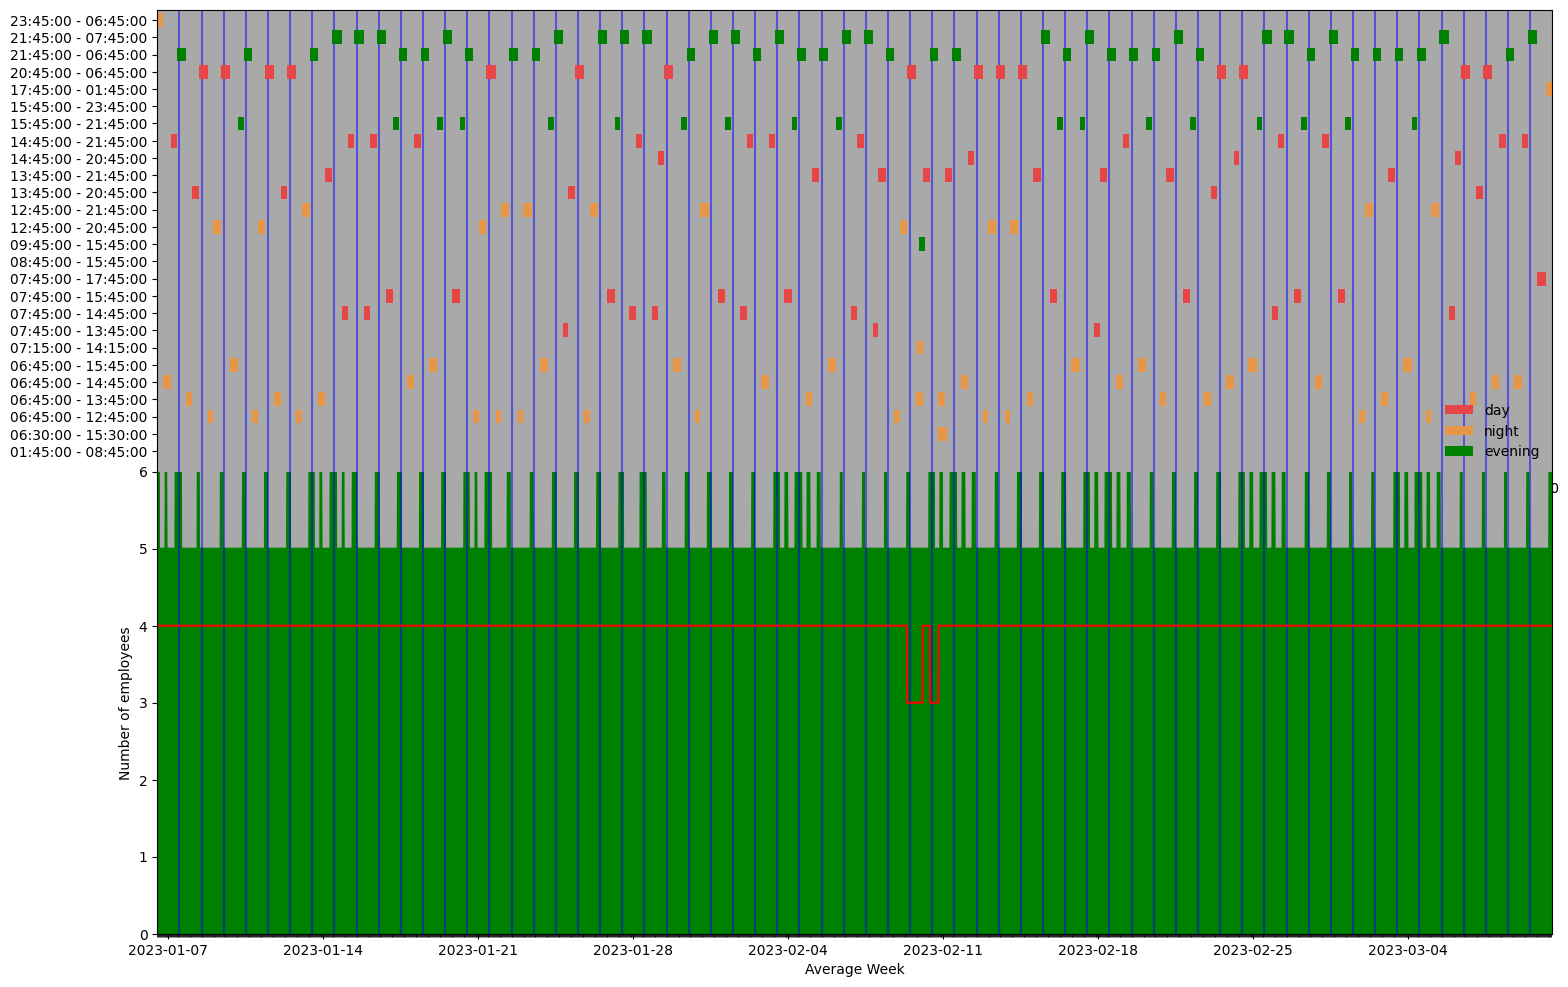

Average overstaffing: -1.1422526041666667
Maximum overcoverage: -1.0
Total cost: 2195344.0


In [3]:

def plot_resulting_schedule(result, assigned, n_weeks):
    p = 60//15
    # c_dict = {'day':'#E64646', 'night':'#E69646', "evening" : "green"}
    colors = {"background" : "darkgray", "shifts_colors" : shift_page.color.c_dict, "staffing levels" : "green", "assigned levels" : "red", "vlines" : "blue"}

    fig, axs = plt.subplots(2, 1, figsize=(18,12), sharex= False)
    bars = axs[0].barh(result["start-end"], result.len, left=result.start_num, zorder = 2, color = result.color)
    y_max = 0
    y_min = 0
    for rect in bars:
        if rect.get_y() + rect.get_height() > y_max:
            y_max = rect.get_y() + rect.get_height()
        if rect.get_y() - rect.get_height() < y_min:
            y_min = rect.get_y() - rect.get_height()

    # for idx, row in result.iterrows():
    #     axs[0].text(row.start_num + 1, row["start-end"], 
    #             f"{row.Shift_name.replace('-', '').replace('>', '')}", 
    #             va='center', alpha=0.8)

    legend_elements = [Patch(facecolor= colors["shifts_colors"][i], label=i)  for i in colors["shifts_colors"]]
    axs[0].legend(handles=legend_elements, facecolor = colors["background"], framealpha=0)

    for day in range(0,(24*7*p*n_weeks), 24*p):
        axs[0].vlines(x = day, ymin = y_min, ymax =y_max + 0.2, color = colors["vlines"], zorder = 1, alpha = .5)
        
    axs[0].set_xticks(list(range(12*p,(24*7*p*n_weeks), 24*p)))
    # axs[0].set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    xticks_minor = list(range(24*7*p*n_weeks))
    axs[0].set_xticks(xticks_minor, minor=True)
    axs[0].set_ylim(ymin= y_min, ymax = y_max + 0.2)
    axs[0].set_xlim(xmin= 0, xmax = 24*7*p*n_weeks)
    axs[0].spines["bottom"].set_visible(False)
    axs[0].set_facecolor(colors["background"])

    axs[1].plot(assigned.index, assigned.Assigned,zorder = 2, color = colors["assigned levels"])
    axs[1].plot(assigned.index, assigned.Staffing_level,zorder = 1, color = colors["staffing levels"])
    axs[1].fill_between(assigned.index, assigned.Staffing_level, color = colors["staffing levels"], zorder = 1)
    for day in range(0,(24*7*p*n_weeks), 24*p):
        axs[1].vlines(x = day, ymin = 0, ymax =max(assigned.Assigned.max(), assigned.Staffing_level.max()) +0.2, color = colors["vlines"], zorder = 1, alpha = .5)
    axs[1].set_xticks(list(range(12*p,(24*7*p*n_weeks) + 8 , 24*p*7)))
    axs[1].set_xticklabels([str(n_assigned["date"].tolist()[x])[:10] for x in list(range(12*p,(24*7*p*n_weeks) + 8 , 24*p*7))])
    xticks_minor = list(range(0 ,24*7*p*n_weeks,p))
    axs[1].set_xticks(xticks_minor, minor=True)
    axs[1].set_xlim(xmin= 0, xmax = 24*7*p*n_weeks)
    axs[1].set_ylim(ymin= 0, ymax = max(assigned.Assigned.max(), assigned.Staffing_level.max()))
    axs[1].spines['top'].set_visible(False)
    axs[1].set_facecolor(colors["background"])
    axs[1].set_ylabel("Number of employees")
    axs[1].set_xlabel("Average Week")
    fig.patch.set_facecolor("white")
    plt.subplots_adjust(wspace=0, hspace =0)
    return fig
schedule_graph = plot_resulting_schedule(results.sort_values("start-end"), n_assigned, n_weeks)
plt.show()
n_assigned["OverStaffing"] = n_assigned["Assigned"] - n_assigned["Staffing_level"]
print(f"Average overstaffing: {n_assigned.OverStaffing.mean()}")
print(f"Maximum overcoverage: {n_assigned.OverStaffing.max()}")
print(f"Total cost: {pyo.value(opt_model.Tot_Costs)}")
